In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm
import time

In [ ]:
# ESRGAN Generator Network

class ESRGANGenerator(nn.Module):
    def __init__(self, num_rrdb=28, residual_scaling=0.15, init_variance=0.03):
        super(ESRGANGenerator, self).__init__()
        self.num_rrdb = num_rrdb
        self.residual_scaling = residual_scaling
        self.init_variance = init_variance

        self.conv_in = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.rrdb_blocks = nn.ModuleList([RRDB(64, self.residual_scaling, self.init_variance) for _ in range(self.num_rrdb)])
        self.upscale1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.upscale2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv_out = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = self.conv_in(x)
        residual = out

        for rrdb in self.rrdb_blocks:
            out = rrdb(out)

        out = self.upscale1(out)
        out = self.upscale2(out)
        out = self.conv_out(out)

        return out + residual

In [ ]:
# RRDB (Residual-in-Residual Dense Block) module

class RRDB(nn.Module):
    def __init__(self, channels, residual_scaling, init_variance):
        super(RRDB, self).__init__()
        self.res_dense_blocks = nn.ModuleList([ResidualDenseBlock(channels, init_variance) for _ in range(3)])
        self.residual_scaling = residual_scaling

    def forward(self, x):
        out = x
        for res_dense_block in self.res_dense_blocks:
            out = res_dense_block(out)
        return x + self.residual_scaling * out

In [ ]:
# Residual Dense Block module

class ResidualDenseBlock(nn.Module):
    def __init__(self, channels, init_variance):
        super(ResidualDenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(channels * 2, channels, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(channels * 3, channels, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(channels * 4, channels, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(channels * 5, channels, kernel_size=3, stride=1, padding=1)

        self.init_weights(init_variance)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(torch.cat([x, conv1], dim=1))
        conv3 = self.conv3(torch.cat([x, conv1, conv2], dim=1))
        conv4 = self.conv4(torch.cat([x, conv1, conv2, conv3], dim=1))
        out = self.conv5(torch.cat([x, conv1, conv2, conv3, conv4], dim=1))
        return out + x

    def init_weights(self, init_variance):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0, std=init_variance)
                nn.init.constant_(m.bias, 0)

In [ ]:
# ESRGAN Discriminator Network

class ESRGANDiscriminator(nn.Module):
    def __init__(self, num_conv_layers=14):
        super(ESRGANDiscriminator, self).__init__()
        self.num_conv_layers = num_conv_layers

        self.conv_layers = nn.ModuleList([
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            *[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1) for _ in range(self.num_conv_layers - 1)],
            nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)
        ])

        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        out = x
        for conv_layer in self.conv_layers:
            out = conv_layer(out)
            out = self.leaky_relu(out)
        return out

In [ ]:
def train_esrgan(generator,
                 discriminator,
                 dataloader,
                 optimizer_G, optimizer_D,
                 adversarial_loss_weight=0.01, content_loss_weight=0.03,
                 num_epochs=100,
                 gradient_clip_value=0.5):

    # Loss functions
    adversarial_loss = nn.BCEWithLogitsLoss()
    content_loss = nn.L1Loss()

    for epoch in range(num_epochs):
        for images, _ in dataloader:

            # training the discriminator
            real_output = discriminator(images)
            fake_output = discriminator(generator(images.detach()))
            disc_real_loss = adversarial_loss(real_output, torch.ones_like(real_output))
            disc_fake_loss = adversarial_loss(fake_output, torch.zeros_like(fake_output))
            disc_loss = disc_real_loss + disc_fake_loss
            optimizer_D.zero_grad()
            disc_loss.backward()
            torch.nn.utils.clip_grad_value_(discriminator.parameters(), gradient_clip_value)
            optimizer_D.step()

            # training the generator
            fake_output = discriminator(generator(images))
            gen_adversarial_loss = adversarial_loss(fake_output, torch.ones_like(fake_output))
            gen_content_loss = content_loss(generator(images), images)
            gen_loss = adversarial_loss_weight * gen_adversarial_loss + content_loss_weight * gen_content_loss
            optimizer_G.zero_grad()
            gen_loss.backward()
            torch.nn.utils.clip_grad_value_(generator.parameters(), gradient_clip_value)
            optimizer_G.step()

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch.optim as optim

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def custom_loader(path):
    img = Image.open(path)
    return transform(img)

dataset = datasets.ImageFolder('/content/dataset', loader=custom_loader)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = ESRGANGenerator(num_rrdb=28, residual_scaling=0.15, init_variance=0.03).to(device)
discriminator = ESRGANDiscriminator(num_conv_layers=14).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4)

In [ ]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Experiment 1
# exp1_generator = ESRGANGenerator(num_rrdb=8, residual_scaling=0.1, init_variance=0.01).to(device)
# exp1_discriminator = ESRGANDiscriminator(num_conv_layers=5).to(device)
# exp1_optimizer_G = optim.Adam(exp1_generator.parameters(), lr=1e-4)
# exp1_optimizer_D = optim.Adam(exp1_discriminator.parameters(), lr=1e-4)

# # Experiment 2
# exp2_generator = ESRGANGenerator(num_rrdb=16, residual_scaling=0.2, init_variance=0.05).to(device)
# exp2_discriminator = ESRGANDiscriminator(num_conv_layers=7).to(device)
# exp2_optimizer_G = optim.Adam(exp2_generator.parameters(), lr=1e-4)
# exp2_optimizer_D = optim.Adam(exp2_discriminator.parameters(), lr=1e-4)

# # Experiment 3
# exp3_generator = ESRGANGenerator(num_rrdb=24, residual_scaling=0.15, init_variance=0.03).to(device)
# exp3_discriminator = ESRGANDiscriminator(num_conv_layers=12).to(device)
# exp3_optimizer_G = optim.Adam(exp3_generator.parameters(), lr=1e-4)
# exp3_optimizer_D = optim.Adam(exp3_discriminator.parameters(), lr=1e-4)

# # Experiment 4
# exp4_generator = ESRGANGenerator(num_rrdb=14, residual_scaling=0.3, init_variance=0.01).to(device)
# exp4_discriminator = ESRGANDiscriminator(num_conv_layers=8).to(device)
# exp4_optimizer_G = optim.RMSprop(exp4_generator.parameters(), lr=2e-4)
# exp4_optimizer_D = optim.RMSprop(exp4_discriminator.parameters(), lr=2e-4)

# # Experiment 5
# exp5_generator = ESRGANGenerator(num_rrdb=32, residual_scaling=0.2, init_variance=0.025).to(device)
# exp5_discriminator = ESRGANDiscriminator(num_conv_layers=9).to(device)
# exp5_optimizer_G = optim.SGD(exp5_generator.parameters(), lr=2e-4)
# exp5_optimizer_D = optim.SGD(exp5_discriminator.parameters(), lr=2e-4)

# # Experiment 6
# exp6_generator = ESRGANGenerator(num_rrdb=12, residual_scaling=0.1, init_variance=0.015).to(device)
# exp6_discriminator = ESRGANDiscriminator(num_conv_layers=28).to(device)
# exp6_optimizer_G = optim.SGD(exp6_generator.parameters(), lr=1e-4)
# exp6_optimizer_D = optim.SGD(exp6_discriminator.parameters(), lr=1e-4)

# Experiment 7
exp7_generator = ESRGANGenerator(num_rrdb=28, residual_scaling=0.15, init_variance=0.03).to(device)
exp7_discriminator = ESRGANDiscriminator(num_conv_layers=14).to(device)
exp7_optimizer_G = optim.Adam(exp7_generator.parameters(), lr=1e-4)
exp7_optimizer_D = optim.Adam(exp7_discriminator.parameters(), lr=1e-4)

# # Experiment 8
# exp8_generator = ESRGANGenerator(num_rrdb=16, residual_scaling=0.3, init_variance=0.01).to(device)
# exp8_discriminator = ESRGANDiscriminator(num_conv_layers=10).to(device)
# exp8_optimizer_G = optim.RMSprop(exp8_generator.parameters(), lr=2e-4)
# exp8_optimizer_D = optim.RMSprop(exp8_discriminator.parameters(), lr=2e-4)

# # Experiment 9
# exp9_generator = ESRGANGenerator(num_rrdb=32, residual_scaling=0.1, init_variance=0.015).to(device)
# exp9_discriminator = ESRGANDiscriminator(num_conv_layers=24).to(device)
# exp9_optimizer_G = optim.RMSprop(exp9_generator.parameters(), lr=2e-4)
# exp9_optimizer_D = optim.RMSprop(exp9_discriminator.parameters(), lr=2e-4)

# # Experiment 10
# exp10_generator = ESRGANGenerator(num_rrdb=16, residual_scaling=0.2, init_variance=0.02).to(device)
# exp10_discriminator = ESRGANDiscriminator(num_conv_layers=32).to(device)
# exp10_optimizer_G = optim.SGD(exp10_generator.parameters(), lr=1e-4)
# exp10_optimizer_D = optim.SGD(exp10_discriminator.parameters(), lr=1e-4)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch.optim as optim
import os

num_epochs = 100
total_adversarial_loss = 0
total_content_loss = 0

for epoch in range(num_epochs):
    real_output = discriminator(dataloader.dataset[0][0].to(device))
    fake_output = discriminator(generator(dataloader.dataset[0][0].unsqueeze(0).to(device)))
    disc_real_loss = adversarial_loss(real_output, torch.ones_like(real_output).to(device))
    disc_fake_loss = adversarial_loss(fake_output, torch.zeros_like(fake_output).to(device))
    disc_loss = disc_real_loss + disc_fake_loss
    optimizer_D.zero_grad()
    disc_loss.backward()
    torch.nn.utils.clip_grad_value_(discriminator.parameters(), 0.5)
    optimizer_D.step()

    fake_output = discriminator(generator(dataloader.dataset[0][0].unsqueeze(0).to(device)))
    gen_adversarial_loss = adversarial_loss(fake_output, torch.ones_like(fake_output).to(device))
    gen_content_loss = content_loss(generator(dataloader.dataset[0][0].unsqueeze(0).to(device)), dataloader.dataset[0][0].unsqueeze(0).to(device))
    gen_loss = adversarial_loss_weight * gen_adversarial_loss + content_loss_weight * gen_content_loss
    optimizer_G.zero_grad()
    gen_loss.backward()
    torch.nn.utils.clip_grad_value_(generator.parameters(), 0.5)
    optimizer_G.step()

    total_adversarial_loss += gen_adversarial_loss.item()
    total_content_loss += gen_content_loss.item()

    if (epoch + 1) % 10 == 0:
        checkpoint_dir = "/content/models"
        os.makedirs(checkpoint_dir, exist_ok=True)
        torch.save({
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'optimizer_G': optimizer_G.state_dict(),
            'optimizer_D': optimizer_D.state_dict()
        }, os.path.join(checkpoint_dir, f"isic_gen_e_{epoch+1}.h5"))

    # if (epoch + 1) % 10 == 0:
    #     checkpoint_dir = "/content/models"
    #     os.makedirs(checkpoint_dir, exist_ok=True)
    #     torch.save({
    #         'generator': generator.state_dict(),
    #         'discriminator': discriminator.state_dict(),
    #         'optimizer_G': optimizer_G.state_dict(),
    #         'optimizer_D': optimizer_D.state_dict()
    #     }, os.path.join(checkpoint_dir, f"ham10000_gen_e_{epoch+1}.h5"))

In [ ]:
print(f"Average Adversarial loss : {total_adversarial_loss / num_epochs:.2f}")
print(f"Average Content loss     : {total_content_loss / num_epochs:.2f}")

Average Adversarial loss : 0.01
Average Content loss     : 0.03


In [ ]:
original_images_dir = '/content/dataset/'
# original_images_dir = '/content/ham10000_dataset/'

!mkdir /content/dataset/hr_images
!mkdir /content/dataset/lr_images

# !mkdir /content/ham10000_dataset/hr_images
# !mkdir /content/ham10000_dataset/lr_images

In [ ]:
hr_images_dir = '/content/dataset/hr_images/'
lr_images_dir = '/content/dataset/lr_images/'

# hr_images_dir = '/content/ham10000_dataset/hr_images/'
# lr_images_dir = '/content/ham10000_dataset/lr_images/'

In [ ]:
image_files = os.listdir(original_images_dir)

for img in image_files:
    img_path = os.path.join(original_images_dir, img)
    img_array = cv2.imread(img_path)

    if img_array is not None:
        hr_img_array = cv2.resize(img_array, (128, 128))
        lr_img_array = cv2.resize(img_array, (32, 32))
        cv2.imwrite(os.path.join(hr_images_dir, img), hr_img_array)
        cv2.imwrite(os.path.join(lr_images_dir, img), lr_img_array)
    else:
        print(f"Failed to load image: {img_path}")

In [ ]:
lr_list = os.listdir("/content/dataset/lr_images/")
hr_list = os.listdir("/content/dataset/hr_images")

# lr_list = os.listdir("/content/ham10000_dataset/lr_images/")
# hr_list = os.listdir("/content/ham10000_dataset/hr_images")

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/content/dataset/lr_images/" + img)
    # img_lr = cv2.imread("/content/ham10000_dataset/lr_images/" + img)

    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)

hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/content/dataset/hr_images/" + img)
    # img_hr = cv2.imread("/content/ham10000_dataset/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

In [ ]:
lr_images = lr_images / 255.
hr_images = hr_images / 255.

lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images,
                                                        hr_images,
                                                        test_size=0.33,
                                                        random_state=42)

hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

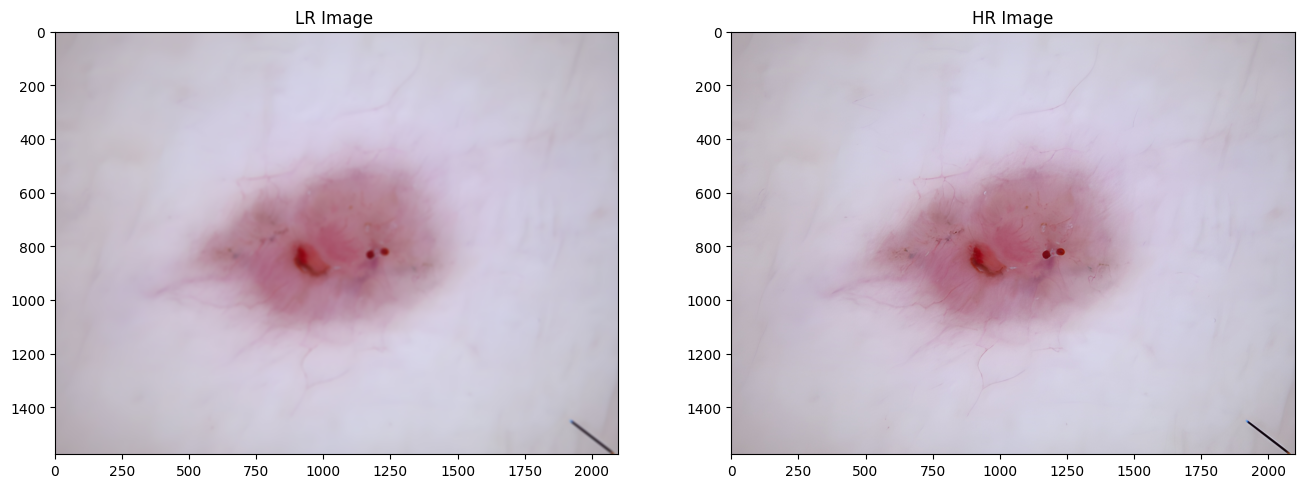

In [ ]:
import matplotlib.pyplot as plt
import cv2
from keras.models import load_model
from numpy.random import randint

# loading the 10th model
generator = load_model('/content/model/isic_gen_e_100.h5', compile=False)

[X1, X2] = [lr_test, hr_test]
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
gen_image = generator.predict(src_image)

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("LR Image")
plt.imshow(src_image[0,:,:,:])

plt.subplot(122)
plt.title("HR Image)")
plt.imshow(gen_image[0,:,:,:])

plt.show()

In [ ]:
import os

generated_dir = '/content/generated'
# generated_dir = '/content/ham10000_generated'

if not os.path.exists(generated_dir):
    os.makedirs(generated_dir)

generator = load_model('/content/model/isic_gen_e_100.h5', compile=False)
# generator = load_model('/content/model/ham10000_gen_e_100.h5', compile=False)

[X1, X2] = [lr_test, hr_test]
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
gen_image = generator.predict(src_image)

# saving the generated image
generated_image_path = os.path.join(generated_dir, 'generated_image.jpg')
cv2.imwrite(generated_image_path, (gen_image[0] * 255).astype(np.uint8))

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr

In [ ]:
# Function to calculate PSNR

def calculate_psnr(original, enhanced):
    mse = np.mean((original - enhanced) ** 2)
    if mse == 0:
        return float('inf')
    R = 255.0
    psnr = 10 * np.log10((R ** 2) / mse)
    return psnr

In [ ]:
# Function to calculate SSIM

def calculate_ssim(original, enhanced, win_size=11):
    score, _ = ssim(original, enhanced, full=True, multichannel=True, win_size=win_size, channel_axis=-1)
    return score

In [ ]:
# Function to calculate Perceptual Index (PI)

def calculate_pi(original, enhanced):
    if original.shape != enhanced.shape:
        enhanced = cv2.resize(enhanced, original.shape[:2][::-1])

    # Calculate the Ma's Metric
    img_diff = np.abs(original.astype(np.float32) - enhanced.astype(np.float32))
    ma_score = np.exp(-np.mean(img_diff))
    return ma_score

In [ ]:
# Function to calculate Spatial Correlation Coefficient (SCC)

def calculate_scc(original, enhanced):
    original_flat = original.reshape(-1)
    enhanced_flat = enhanced.reshape(-1)
    scc_score, _ = pearsonr(original_flat, enhanced_flat)
    return scc_score

In [ ]:
# Function to calculate Naturalness Image Quality Evaluator (NIQE)

def calculate_niqe(enhanced):
    if len(enhanced.shape) == 3 and enhanced.shape[2] == 3:
        enhanced = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)

    mu = np.mean(enhanced)
    sigma = np.std(enhanced)
    kurtosis = np.mean((enhanced - mu) ** 4) / sigma ** 4
    skewness = np.mean((enhanced - mu) ** 3) / sigma ** 3
    niqe_score = 0.5 * (np.abs(kurtosis - 3) + np.abs(skewness))
    return niqe_score

In [ ]:
original_images_dir = '/content/dataset'
enhanced_images_dir = '/content/generated'

# original_images_dir = '/content/ham10000_dataset'
# enhanced_images_dir = '/content/ham10000_generated'

original_images_paths = [os.path.join(original_images_dir, f) for f in os.listdir(original_images_dir)]
enhanced_images_paths = [os.path.join(enhanced_images_dir, f) for f in os.listdir(enhanced_images_dir)]

In [ ]:
psnr_values = []
ssim_values = []
pi_values = []
scc_values = []
niqe_values = []

In [ ]:
for i in range(len(original_images_paths)):
    original_image = cv2.imread(original_images_paths[i])
    enhanced_image = cv2.imread(enhanced_images_paths[i])

    target_size = (original_image.shape[1], original_image.shape[0])
    enhanced_image = cv2.resize(enhanced_image, target_size)

    psnr_value = calculate_psnr(original_image, enhanced_image)
    ssim_value = calculate_ssim(original_image, enhanced_image)
    pi_value = calculate_pi(original_image, enhanced_image)
    scc_value = calculate_scc(original_image, enhanced_image)
    niqe_value = calculate_niqe(enhanced_image)

    psnr_values.append(psnr_value)
    ssim_values.append(ssim_value)
    pi_values.append(pi_value)
    scc_values.append(scc_value)
    niqe_values.append(niqe_value)

In [ ]:
results = {
    'Metric': ['PSNR', 'SSIM', 'Perceptual Index', 'SCC', 'NIQE'],
    'Value': [np.mean(psnr_values), np.mean(ssim_values), np.mean(pi_values), np.mean(scc_values), np.mean(niqe_values)]
}

results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv('isic_image_enhancement_evaluation.csv', index=False)

             Metric      Value
0              PSNR  40.103805
1              SSIM   0.964047
2  Perceptual Index   0.145754
3               SCC   0.997856
4              NIQE   0.194850


In [ ]:
# results = {
#     'Metric': ['PSNR', 'SSIM', 'Perceptual Index', 'SCC', 'NIQE'],
#     'Value': [np.mean(psnr_values), np.mean(ssim_values), np.mean(pi_values), np.mean(scc_values), np.mean(niqe_values)]
# }

# results_df = pd.DataFrame(results)
# print(results_df)
# results_df.to_csv('ham10000_image_enhancement_evaluation.csv', index=False)

             Metric      Value
0              PSNR  39.011783
1              SSIM   0.975121
2  Perceptual Index   0.140137
3               SCC   0.986603
5              NIQE   0.152844
